In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

data = pd.read_csv('dataset.csv')

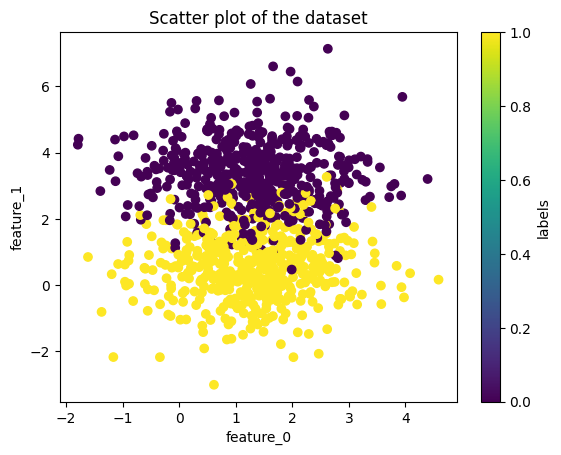

In [ ]:
plt.scatter(data[data.columns[1]], data[data.columns[2]], c=data[data.columns[3]], cmap='viridis', marker='o')
plt.xlabel(data.columns[1])
plt.ylabel(data.columns[2])
plt.title('Scatter plot of the dataset')
plt.colorbar(label=data.columns[3])
plt.show()

Είναι γραμμικά διαχωρίσιμος, καθώς μπορούμε να χωρίσουμε τις δύο κλάσεις αν τραβήξουμε μια γραμμή.

In [ ]:
def train_single_sample(a, y, labels, n_iterations, lr, n_samples, variable_lr=False):

    best_model = None
    best_accuracy = 0.0
    accuracy_history = []

    for k in tqdm(range(1, n_iterations + 1), desc="Training Progress"):
        # Choose data point
        idx = k % len(y)
        x_k = y[idx]
        label_k = labels[idx]

        # Check if the current data point is misclassified
        if label_k * np.dot(a, x_k) <= 0:
            # Update weight vector
            a += lr * label_k * x_k

            if variable_lr:
                lr *= 0.95  # Decay learning rate if specified

        # Compute accuracy every n_samples
        if k % n_samples == 0:
            accuracy = compute_accuracy(a, y, labels)
            accuracy_history.append(accuracy)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = np.copy(a)

    return best_model, accuracy_history


def compute_accuracy(a, y, labels):

    predictions = np.sign(np.dot(y, a))  # Compute predictions
    correct_predictions = (predictions == labels).sum()  # Count correct predictions
    accuracy = correct_predictions / len(labels)  # Compute accuracy
    return accuracy

In [ ]:
def plot_model(weights, bias, data, labels):
    # Create a meshgrid to plot decision boundaries
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Append bias term to the weights
    extended_weights = np.append(weights, bias)

    # Predict labels for each point in the meshgrid
    Z = np.sign(np.dot(np.c_[xx.ravel(), yy.ravel(), np.ones_like(xx).ravel()], extended_weights))
    Z = Z.reshape(xx.shape)

    # Plot decision boundaries
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    # Plot data points
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundaries of the Model')
    plt.show()


Training Progress: 100%|██████████| 100000/100000 [00:00<00:00, 310572.78it/s]


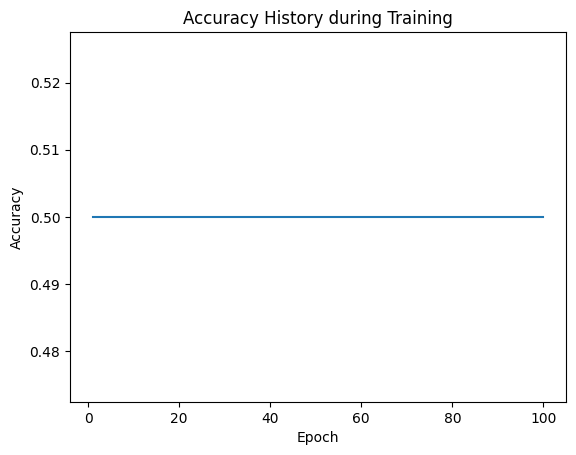

Shape of best_weights: (3,)


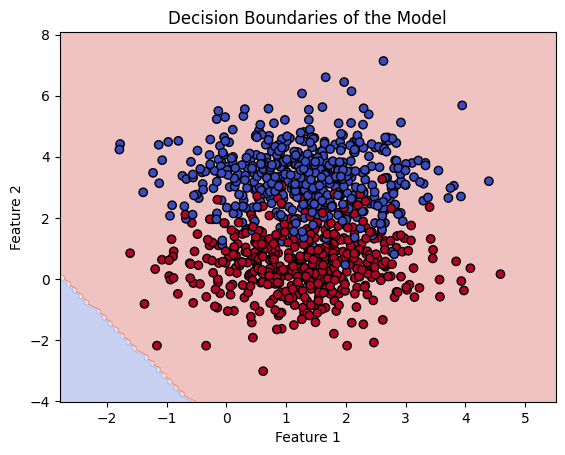

In [ ]:
# Define hyperparameters
n_iterations = 100000
lr = 1
variable_lr = False

# Get the number of data points
n_samples = len(data)

# Train linear model
best_weights, acc_history = train_single_sample(a=np.zeros(3),
                                                y=np.c_[data[['feature_0', 'feature_1']], np.ones(len(data))],
                                                labels=data['labels'].values,
                                                n_iterations=n_iterations,
                                                lr=lr,
                                                n_samples=n_samples,
                                                variable_lr=variable_lr)

# Extract weights and bias
weights = best_weights[:-1]  # Extracting weights, excluding the bias term
bias = best_weights[-1]  # Extracting the bias term

# Plot accuracy history
plt.plot(range(1, n_iterations // n_samples + 1), acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy History during Training')
plt.show()


# Ensure data has correct shape
X = data[['feature_0', 'feature_1']].values
y = data['labels'].values

# Plot data along with trained model
plot_model(weights, bias, X, y)

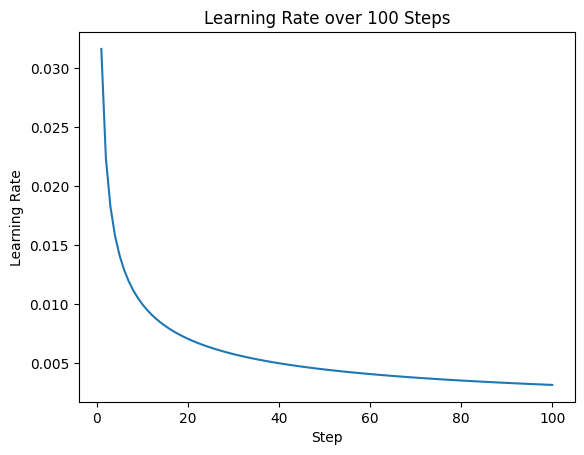

In [ ]:
class Scheduler:
    def __init__(self, n_samples):
        self.n_samples = n_samples
        self.k = 0

    def get_next_lr(self):
        self.k += 1
        return 1 / np.sqrt(self.k * self.n_samples)

# Test the Scheduler class
n_samples = 1000
scheduler = Scheduler(n_samples)
learning_rates = [scheduler.get_next_lr() for _ in range(100)]
plt.plot(range(1, 101), learning_rates)
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over 100 Steps')
plt.show()

Training Progress: 100%|██████████| 100000/100000 [00:01<00:00, 67173.55it/s]


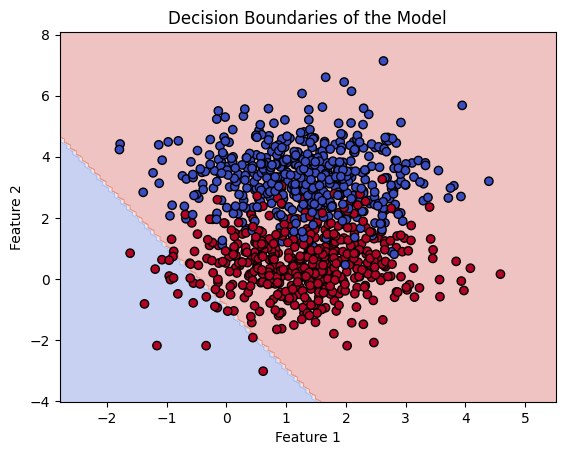

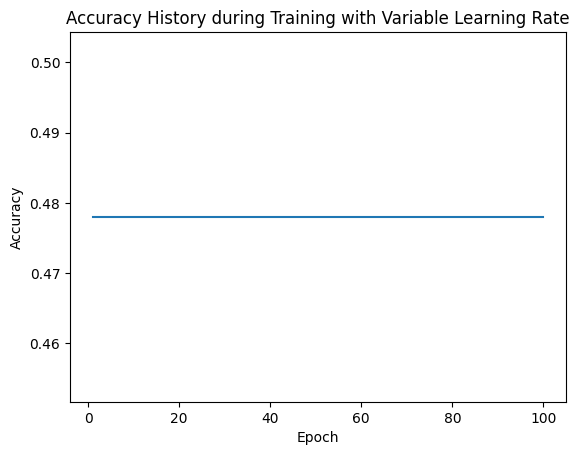

In [ ]:
# Define hyperparameters
n_iterations = 100000
n_samples = 1000

# Initialize Scheduler object
scheduler = Scheduler(n_samples)

# Calculate initial learning rate
initial_lr = scheduler.get_next_lr()

# Train linear model with variable learning rate
best_weights_var_lr, acc_history_var_lr = train_single_sample(
    a=np.zeros(3),
    y=np.c_[data[['feature_0', 'feature_1']], np.ones(len(data))],
    labels=data['labels'].values,
    n_iterations=n_iterations,
    lr=initial_lr,  # Initial learning rate
    n_samples=n_samples,
    variable_lr=True
)

# Plot dataset and trained model decision boundaries
plot_model(best_weights_var_lr[:-1], best_weights_var_lr[-1], X, y)

# Plot accuracy history
plt.plot(range(1, n_iterations // n_samples + 1), acc_history_var_lr)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy History during Training with Variable Learning Rate')
plt.show()

In [ ]:
# Extract features and labels
X = data[['feature_0', 'feature_1']].values
y = data['labels'].values

# Define the train_batch function
def train_batch(X, y, learning_rate, theta, report_period, n_iterations):
    n_samples, n_features = X.shape
    a = np.zeros(n_features)  # Initialize weight vector
    error_history = []  # List to store error values
    accuracy_history = []  # List to store accuracy values
    best_weights = a.copy()
    best_error = float('inf')

    for k in tqdm(range(1, n_iterations + 1)):
        delta_a = np.zeros(n_features)  # Accumulator for weight updates
        total_error = 0  # Initialize total error for this iteration

        # Iterate over all samples
        for i in range(n_samples):
            if y[i] * np.dot(a, X[i]) <= 0:
                delta_a += y[i] * X[i]
                total_error += np.abs(np.dot(y[i], X[i])).sum()  # Ensure total_error is scalar

        # Update weights
        a += learning_rate(k) * delta_a
        error_history.append(total_error)

        # Calculate accuracy
        accuracy = np.mean((np.dot(X, a) * y) > 0)
        accuracy_history.append(accuracy)

        # Check if the current model is the best
        if total_error < best_error:
            best_error = total_error
            best_weights = a.copy()

        # Report model accuracy and error
        if k % (n_samples // report_period) == 0:
            print(f"Iteration {k}: Accuracy = {accuracy:.4f}, Error = {total_error}")

        # Check convergence
        if total_error < theta:
            break

    return best_weights, error_history, accuracy_history

# Fixed learning rate function
def fixed_learning_rate(k):
    return 1.0

# Variable learning rate function
def variable_learning_rate(k):
    return 1.0 / (1 + k)

# Hyperparameters
n_iterations = 100000
theta = 0.01
report_period = 16

# Train with fixed learning rate
best_weights_fixed, error_history_fixed, accuracy_history_fixed = train_batch(
    X, y, fixed_learning_rate, theta, report_period, n_iterations)

# Train with variable learning rate
best_weights_variable, error_history_variable, accuracy_history_variable = train_batch(
    X, y, variable_learning_rate, theta, report_period, n_iterations)

# Plotting function for error and accuracy history
def plot_history(error_history, accuracy_history, title):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Error', color='tab:red')
    ax1.plot(error_history, color='tab:red', label='Error')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(accuracy_history, color='tab:blue', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    plt.title(title)
    plt.show()

# Plot history for fixed learning rate
plot_history(error_history_fixed, accuracy_history_fixed, 'Fixed Learning Rate')

# Plot history for variable learning rate
plot_history(error_history_variable, accuracy_history_variable, 'Variable Learning Rate')

# Plot the data and the trained model
def plot_model(X, y, weights, title):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)

    # Plot the decision boundary
    x_values = np.linspace(min(X[:, 0]), max(X[:, 0]), 200)
    y_values = -(weights[0] * x_values) / weights[1]
    plt.plot(x_values, y_values, label='Decision Boundary')

    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.legend()
    plt.title(title)
    plt.show()

# Plot the data and the trained model for fixed learning rate
plot_model(X, y, best_weights_fixed, 'Trained Model with Fixed Learning Rate')

# Plot the data and the trained model for variable learning rate
plot_model(X, y, best_weights_variable, 'Trained Model with Variable Learning Rate')

  0%|          | 60/100000 [00:00<21:25, 77.77it/s] 

Iteration 62: Accuracy = 0.4590, Error = 55.58523687683779


  0%|          | 150/100000 [00:01<14:23, 115.70it/s]

Iteration 124: Accuracy = 0.4600, Error = 58.00014416994396


  0%|          | 210/100000 [00:02<11:53, 139.79it/s]

Iteration 186: Accuracy = 0.4590, Error = 55.58523687683779


  0%|          | 271/100000 [00:02<11:51, 140.09it/s]

Iteration 248: Accuracy = 0.4580, Error = 55.58523687683779


  0%|          | 333/100000 [00:02<11:23, 145.86it/s]

Iteration 310: Accuracy = 0.4510, Error = 116.32212988318402


  0%|          | 394/100000 [00:03<11:45, 141.22it/s]

Iteration 372: Accuracy = 0.4590, Error = 55.58523687683779


  0%|          | 455/100000 [00:03<11:25, 145.16it/s]

Iteration 434: Accuracy = 0.4590, Error = 56.14727891278318


  1%|          | 517/100000 [00:04<12:24, 133.68it/s]

Iteration 496: Accuracy = 0.4610, Error = 51.636046042664276


  1%|          | 578/100000 [00:04<11:43, 141.24it/s]

Iteration 558: Accuracy = 0.4610, Error = 50.642233458606235


  1%|          | 640/100000 [00:05<11:09, 148.31it/s]

Iteration 620: Accuracy = 0.4590, Error = 55.58523687683779


  1%|          | 700/100000 [00:05<11:17, 146.56it/s]

Iteration 682: Accuracy = 0.4430, Error = 449.30735206580323


  1%|          | 762/100000 [00:05<11:16, 146.60it/s]

Iteration 744: Accuracy = 0.4480, Error = 508.74079357202817


  1%|          | 820/100000 [00:06<12:02, 137.19it/s]

Iteration 806: Accuracy = 0.4590, Error = 55.833896684130394


  1%|          | 896/100000 [00:06<11:21, 145.46it/s]

Iteration 868: Accuracy = 0.4590, Error = 55.58523687683779


  1%|          | 957/100000 [00:07<11:19, 145.80it/s]

Iteration 930: Accuracy = 0.4580, Error = 56.14727891278318


  1%|          | 1001/100000 [00:07<14:09, 116.59it/s]

Iteration 992: Accuracy = 0.4580, Error = 58.779155719473074


  1%|          | 1066/100000 [00:08<18:56, 87.04it/s]

Iteration 1054: Accuracy = 0.0420, Error = 56.14727891278318


  1%|          | 1131/100000 [00:09<19:08, 86.12it/s]

Iteration 1116: Accuracy = 0.4590, Error = 55.58523687683779


  1%|          | 1195/100000 [00:10<18:57, 86.88it/s]

Iteration 1178: Accuracy = 0.4590, Error = 55.58523687683779


  1%|▏         | 1250/100000 [00:10<19:29, 84.43it/s]

Iteration 1240: Accuracy = 0.4590, Error = 57.213856491074246


  1%|▏         | 1325/100000 [00:11<12:09, 135.34it/s]

Iteration 1302: Accuracy = 0.4590, Error = 55.58523687683779


  1%|▏         | 1385/100000 [00:11<11:25, 143.87it/s]

Iteration 1364: Accuracy = 0.4580, Error = 58.00014416994396


  1%|▏         | 1445/100000 [00:12<11:20, 144.79it/s]

Iteration 1426: Accuracy = 0.4600, Error = 58.00014416994396


  2%|▏         | 1507/100000 [00:12<11:08, 147.30it/s]

Iteration 1488: Accuracy = 0.4600, Error = 51.636046042664276


  2%|▏         | 1568/100000 [00:12<11:33, 142.03it/s]

Iteration 1550: Accuracy = 0.3790, Error = 52.48192245763764


  2%|▏         | 1630/100000 [00:13<11:06, 147.55it/s]

Iteration 1612: Accuracy = 0.4190, Error = 54.885737848634655


  2%|▏         | 1691/100000 [00:13<11:19, 144.58it/s]

Iteration 1674: Accuracy = 0.4600, Error = 51.636046042664276


  2%|▏         | 1751/100000 [00:14<11:47, 138.95it/s]

Iteration 1736: Accuracy = 0.1460, Error = 58.273463123975624


  2%|▏         | 1811/100000 [00:14<11:21, 143.99it/s]

Iteration 1798: Accuracy = 0.4600, Error = 52.48192245763764


  2%|▏         | 1887/100000 [00:15<11:34, 141.27it/s]

Iteration 1860: Accuracy = 0.4520, Error = 79.69350873405708


  2%|▏         | 1947/100000 [00:15<11:13, 145.61it/s]

Iteration 1922: Accuracy = 0.4510, Error = 634.3294940843618


  2%|▏         | 2009/100000 [00:15<11:17, 144.56it/s]

Iteration 1984: Accuracy = 0.4600, Error = 52.48192245763764


  2%|▏         | 2069/100000 [00:16<11:38, 140.26it/s]

Iteration 2046: Accuracy = 0.4590, Error = 52.48192245763764


  2%|▏         | 2130/100000 [00:16<11:19, 144.13it/s]

Iteration 2108: Accuracy = 0.4580, Error = 56.14727891278318


  2%|▏         | 2175/100000 [00:17<12:38, 128.99it/s]

Iteration 2170: Accuracy = 0.4590, Error = 55.58523687683779


  2%|▏         | 2242/100000 [00:18<22:38, 71.95it/s]

Iteration 2232: Accuracy = 0.4600, Error = 51.636046042664276


  2%|▏         | 2319/100000 [00:18<12:13, 133.22it/s]

Iteration 2294: Accuracy = 0.4590, Error = 55.58523687683779


  2%|▏         | 2374/100000 [00:19<12:58, 125.32it/s]

Iteration 2356: Accuracy = 0.4590, Error = 55.58523687683779


  2%|▏         | 2435/100000 [00:19<11:31, 141.19it/s]

Iteration 2418: Accuracy = 0.4600, Error = 58.00014416994396


  2%|▏         | 2496/100000 [00:20<11:15, 144.31it/s]

Iteration 2480: Accuracy = 0.4590, Error = 55.58523687683779


  3%|▎         | 2557/100000 [00:20<11:11, 145.14it/s]

Iteration 2542: Accuracy = 0.4590, Error = 52.78894394637114


  3%|▎         | 2615/100000 [00:21<14:56, 108.57it/s]

Iteration 2604: Accuracy = 0.2490, Error = 59.40948211660079


  3%|▎         | 2673/100000 [00:21<24:35, 65.94it/s]

Iteration 2666: Accuracy = 0.4580, Error = 50.836989423303585


  3%|▎         | 2742/100000 [00:22<19:32, 82.97it/s]

Iteration 2728: Accuracy = 0.4610, Error = 51.636046042664276


  3%|▎         | 2802/100000 [00:23<23:01, 70.35it/s]

Iteration 2790: Accuracy = 0.4600, Error = 57.213856491074246


  3%|▎         | 2879/100000 [00:24<12:14, 132.15it/s]

Iteration 2852: Accuracy = 0.4600, Error = 58.00014416994396


  3%|▎         | 2936/100000 [00:24<12:15, 132.04it/s]

Iteration 2914: Accuracy = 0.4580, Error = 54.885737848634655


  3%|▎         | 2997/100000 [00:25<11:16, 143.30it/s]

Iteration 2976: Accuracy = 0.4590, Error = 55.58523687683779


  3%|▎         | 3057/100000 [00:25<11:21, 142.34it/s]

Iteration 3038: Accuracy = 0.4590, Error = 55.58523687683779


  3%|▎         | 3118/100000 [00:25<11:09, 144.62it/s]

Iteration 3100: Accuracy = 0.4570, Error = 53.45844149302348


  3%|▎         | 3181/100000 [00:26<11:19, 142.39it/s]

Iteration 3162: Accuracy = 0.4590, Error = 55.58523687683779


  3%|▎         | 3241/100000 [00:26<11:26, 140.92it/s]

Iteration 3224: Accuracy = 0.4610, Error = 51.636046042664276


  3%|▎         | 3302/100000 [00:27<11:01, 146.08it/s]

Iteration 3286: Accuracy = 0.4580, Error = 57.11838672977401


  3%|▎         | 3378/100000 [00:27<11:06, 144.91it/s]

Iteration 3348: Accuracy = 0.4600, Error = 51.636046042664276


  3%|▎         | 3439/100000 [00:28<10:54, 147.59it/s]

Iteration 3410: Accuracy = 0.4610, Error = 51.636046042664276


  3%|▎         | 3499/100000 [00:28<11:05, 144.92it/s]

Iteration 3472: Accuracy = 0.4610, Error = 51.636046042664276


  4%|▎         | 3559/100000 [00:28<11:24, 140.81it/s]

Iteration 3534: Accuracy = 0.4600, Error = 1072.0736675048531


  4%|▎         | 3604/100000 [00:29<11:30, 139.63it/s]

Iteration 3596: Accuracy = 0.4590, Error = 55.58523687683779


  4%|▎         | 3684/100000 [00:30<13:45, 116.72it/s]

Iteration 3658: Accuracy = 0.4610, Error = 58.00014416994396


  4%|▎         | 3744/100000 [00:30<11:58, 134.06it/s]

Iteration 3720: Accuracy = 0.4610, Error = 51.636046042664276


  4%|▍         | 3805/100000 [00:30<11:08, 144.00it/s]

Iteration 3782: Accuracy = 0.4560, Error = 59.40948211660079


  4%|▍         | 3865/100000 [00:31<10:58, 145.99it/s]

Iteration 3844: Accuracy = 0.4580, Error = 52.48192245763764


  4%|▍         | 3926/100000 [00:31<11:03, 144.82it/s]

Iteration 3906: Accuracy = 0.4540, Error = 156.66951274016935


  4%|▍         | 3988/100000 [00:32<10:50, 147.58it/s]

Iteration 3968: Accuracy = 0.4610, Error = 56.14727891278318


  4%|▍         | 4050/100000 [00:32<11:13, 142.45it/s]

Iteration 4030: Accuracy = 0.4580, Error = 59.40948211660079


  4%|▍         | 4110/100000 [00:32<11:06, 143.93it/s]

Iteration 4092: Accuracy = 0.4590, Error = 52.48192245763764


  4%|▍         | 4170/100000 [00:33<11:24, 139.94it/s]

Iteration 4154: Accuracy = 0.4590, Error = 55.58523687683779


  4%|▍         | 4224/100000 [00:33<15:02, 106.14it/s]

Iteration 4216: Accuracy = 0.4590, Error = 55.58523687683779


  4%|▍         | 4295/100000 [00:34<18:00, 88.61it/s]

Iteration 4278: Accuracy = 0.4600, Error = 52.48192245763764


  4%|▍         | 4350/100000 [00:35<18:31, 86.05it/s]

Iteration 4340: Accuracy = 0.4590, Error = 55.58523687683779


  4%|▍         | 4413/100000 [00:36<18:22, 86.67it/s]

Iteration 4402: Accuracy = 0.4600, Error = 52.48192245763764


  4%|▍         | 4480/100000 [00:36<16:39, 95.56it/s]

Iteration 4464: Accuracy = 0.4590, Error = 58.00014416994396


  5%|▍         | 4557/100000 [00:37<11:14, 141.43it/s]

Iteration 4526: Accuracy = 0.4590, Error = 55.58523687683779


  5%|▍         | 4602/100000 [00:37<11:22, 139.69it/s]

Iteration 4588: Accuracy = 0.4590, Error = 55.58523687683779


  5%|▍         | 4664/100000 [00:38<11:06, 143.08it/s]

Iteration 4650: Accuracy = 0.4590, Error = 55.58523687683779


  5%|▍         | 4740/100000 [00:38<10:53, 145.75it/s]

Iteration 4712: Accuracy = 0.4510, Error = 527.7849792867173


  5%|▍         | 4802/100000 [00:39<10:49, 146.58it/s]

Iteration 4774: Accuracy = 0.4610, Error = 56.14727891278318


  5%|▍         | 4847/100000 [00:39<11:22, 139.42it/s]

Iteration 4836: Accuracy = 0.4610, Error = 52.48192245763764


  5%|▍         | 4910/100000 [00:40<14:43, 107.65it/s]

Iteration 4898: Accuracy = 0.4550, Error = 66.8446722744645


  5%|▍         | 4984/100000 [00:40<11:20, 139.72it/s]

Iteration 4960: Accuracy = 0.4590, Error = 59.457651155534215


  5%|▌         | 5038/100000 [00:41<14:53, 106.29it/s]

Iteration 5022: Accuracy = 0.4600, Error = 52.48192245763764


  5%|▌         | 5108/100000 [00:41<12:26, 127.17it/s]

Iteration 5084: Accuracy = 0.4600, Error = 58.00014416994396


  5%|▌         | 5167/100000 [00:42<11:12, 141.08it/s]

Iteration 5146: Accuracy = 0.2130, Error = 66.8446722744645


  5%|▌         | 5229/100000 [00:42<10:49, 145.85it/s]

Iteration 5208: Accuracy = 0.4590, Error = 55.58523687683779


  5%|▌         | 5289/100000 [00:42<11:17, 139.88it/s]

Iteration 5270: Accuracy = 0.4590, Error = 55.58523687683779


  5%|▌         | 5350/100000 [00:43<10:43, 147.02it/s]

Iteration 5332: Accuracy = 0.4570, Error = 58.42193676949644


  5%|▌         | 5412/100000 [00:43<10:43, 146.95it/s]

Iteration 5394: Accuracy = 0.4590, Error = 53.45844149302348


  5%|▌         | 5472/100000 [00:44<10:54, 144.45it/s]

Iteration 5456: Accuracy = 0.4360, Error = 375.56789072742004


  6%|▌         | 5533/100000 [00:44<10:40, 147.47it/s]

Iteration 5518: Accuracy = 0.4590, Error = 55.58523687683779


  6%|▌         | 5610/100000 [00:45<10:43, 146.74it/s]

Iteration 5580: Accuracy = 0.4580, Error = 55.58523687683779


  6%|▌         | 5672/100000 [00:45<10:51, 144.74it/s]

Iteration 5642: Accuracy = 0.4600, Error = 58.00014416994396


  6%|▌         | 5717/100000 [00:45<11:02, 142.41it/s]

Iteration 5704: Accuracy = 0.4590, Error = 55.58523687683779


  6%|▌         | 5795/100000 [00:46<10:34, 148.46it/s]

Iteration 5766: Accuracy = 0.4590, Error = 55.58523687683779


  6%|▌         | 5856/100000 [00:46<10:49, 144.90it/s]

Iteration 5828: Accuracy = 0.4170, Error = 52.48192245763764


  6%|▌         | 5907/100000 [00:47<15:59, 98.07it/s] 

Iteration 5890: Accuracy = 0.4590, Error = 55.58523687683779


  6%|▌         | 5968/100000 [00:48<17:36, 88.97it/s]

Iteration 5952: Accuracy = 0.4590, Error = 55.58523687683779


  6%|▌         | 6027/100000 [00:48<17:25, 89.92it/s]

Iteration 6014: Accuracy = 0.4610, Error = 59.457651155534215


  6%|▌         | 6082/100000 [00:49<19:25, 80.60it/s]

Iteration 6076: Accuracy = 0.4490, Error = 52.48192245763764


  6%|▌         | 6156/100000 [00:50<16:15, 96.16it/s]

Iteration 6138: Accuracy = 0.4540, Error = 66.8446722744645


  6%|▌         | 6216/100000 [00:50<11:35, 134.79it/s]

Iteration 6200: Accuracy = 0.4600, Error = 52.48192245763764


  6%|▋         | 6291/100000 [00:51<10:55, 142.98it/s]

Iteration 6262: Accuracy = 0.4600, Error = 52.48192245763764


  6%|▋         | 6352/100000 [00:51<10:37, 146.90it/s]

Iteration 6324: Accuracy = 0.4590, Error = 55.58523687683779


  6%|▋         | 6413/100000 [00:52<11:03, 141.04it/s]

Iteration 6386: Accuracy = 0.4610, Error = 51.636046042664276


  6%|▋         | 6474/100000 [00:52<10:36, 146.90it/s]

Iteration 6448: Accuracy = 0.4590, Error = 57.01635215154287


  7%|▋         | 6536/100000 [00:52<10:24, 149.74it/s]

Iteration 6510: Accuracy = 0.4590, Error = 55.58523687683779


  7%|▋         | 6597/100000 [00:53<10:50, 143.50it/s]

Iteration 6572: Accuracy = 0.4570, Error = 65.56386912205954


  7%|▋         | 6658/100000 [00:53<10:37, 146.34it/s]

Iteration 6634: Accuracy = 0.4520, Error = 76.78365703310182


  7%|▋         | 6719/100000 [00:54<11:14, 138.37it/s]

Iteration 6696: Accuracy = 0.4600, Error = 52.48192245763764


  7%|▋         | 6776/100000 [00:54<12:32, 123.83it/s]

Iteration 6758: Accuracy = 0.4580, Error = 55.58523687683779


  7%|▋         | 6835/100000 [00:55<11:07, 139.52it/s]

Iteration 6820: Accuracy = 0.4590, Error = 55.58523687683779


  7%|▋         | 6896/100000 [00:55<11:37, 133.57it/s]

Iteration 6882: Accuracy = 0.4590, Error = 55.58523687683779


  7%|▋         | 6972/100000 [00:56<10:47, 143.60it/s]

Iteration 6944: Accuracy = 0.4580, Error = 58.00014416994396


  7%|▋         | 7019/100000 [00:56<10:36, 146.01it/s]

Iteration 7006: Accuracy = 0.4590, Error = 55.58523687683779


  7%|▋         | 7092/100000 [00:57<11:24, 135.81it/s]

Iteration 7068: Accuracy = 0.3350, Error = 57.09360160220538


  7%|▋         | 7153/100000 [00:57<10:50, 142.75it/s]

Iteration 7130: Accuracy = 0.4590, Error = 55.58523687683779


  7%|▋         | 7214/100000 [00:57<10:48, 143.16it/s]

Iteration 7192: Accuracy = 0.4560, Error = 66.8446722744645


  7%|▋         | 7275/100000 [00:58<10:30, 147.12it/s]

Iteration 7254: Accuracy = 0.4570, Error = 53.45844149302348


  7%|▋         | 7336/100000 [00:58<10:37, 145.27it/s]

Iteration 7316: Accuracy = 0.4590, Error = 56.14727891278318


  7%|▋         | 7397/100000 [00:59<11:02, 139.80it/s]

Iteration 7378: Accuracy = 0.0420, Error = 58.00014416994396


  7%|▋         | 7457/100000 [00:59<10:52, 141.77it/s]

Iteration 7440: Accuracy = 0.4610, Error = 55.66629407848023


  8%|▊         | 7518/100000 [01:00<10:40, 144.47it/s]

Iteration 7502: Accuracy = 0.4610, Error = 50.642233458606235


  8%|▊         | 7576/100000 [01:00<14:39, 105.14it/s]

Iteration 7564: Accuracy = 0.4580, Error = 56.14727891278318


  8%|▊         | 7640/100000 [01:01<17:59, 85.60it/s]

Iteration 7626: Accuracy = 0.4610, Error = 51.636046042664276


  8%|▊         | 7706/100000 [01:02<17:23, 88.48it/s]

Iteration 7688: Accuracy = 0.4510, Error = 69.28463347355952


  8%|▊         | 7760/100000 [01:02<18:07, 84.80it/s]

Iteration 7750: Accuracy = 0.4590, Error = 52.48192245763764


  8%|▊         | 7823/100000 [01:03<18:50, 81.51it/s]

Iteration 7812: Accuracy = 0.4590, Error = 55.58523687683779


  8%|▊         | 7893/100000 [01:04<11:44, 130.71it/s]

Iteration 7874: Accuracy = 0.4600, Error = 52.48192245763764


  8%|▊         | 7955/100000 [01:04<10:38, 144.06it/s]

Iteration 7936: Accuracy = 0.4560, Error = 66.8446722744645


  8%|▊         | 8015/100000 [01:04<10:50, 141.38it/s]

Iteration 7998: Accuracy = 0.4590, Error = 58.00014416994396


  8%|▊         | 8075/100000 [01:05<10:34, 144.89it/s]

Iteration 8060: Accuracy = 0.4600, Error = 52.48192245763764


  8%|▊         | 8144/100000 [01:05<12:44, 120.08it/s]

Iteration 8122: Accuracy = 0.4490, Error = 134.84644684497505


  8%|▊         | 8205/100000 [01:06<10:55, 139.97it/s]

Iteration 8184: Accuracy = 0.4600, Error = 58.00014416994396


  8%|▊         | 8267/100000 [01:06<10:37, 143.94it/s]

Iteration 8246: Accuracy = 0.4610, Error = 51.636046042664276


  8%|▊         | 8328/100000 [01:07<10:35, 144.32it/s]

Iteration 8308: Accuracy = 0.4590, Error = 55.58523687683779


  8%|▊         | 8388/100000 [01:07<10:33, 144.69it/s]

Iteration 8370: Accuracy = 0.4580, Error = 52.48192245763764


  8%|▊         | 8449/100000 [01:08<10:32, 144.81it/s]

Iteration 8432: Accuracy = 0.4540, Error = 643.4818901708276


  9%|▊         | 8509/100000 [01:08<10:34, 144.22it/s]

Iteration 8494: Accuracy = 0.4590, Error = 55.58523687683779


  9%|▊         | 8585/100000 [01:08<10:26, 145.89it/s]

Iteration 8556: Accuracy = 0.4590, Error = 55.58523687683779


  9%|▊         | 8646/100000 [01:09<10:25, 145.94it/s]

Iteration 8618: Accuracy = 0.4580, Error = 52.48192245763764


  9%|▊         | 8708/100000 [01:09<10:29, 145.10it/s]

Iteration 8680: Accuracy = 0.4610, Error = 51.636046042664276


  9%|▉         | 8769/100000 [01:10<10:26, 145.57it/s]

Iteration 8742: Accuracy = 0.4580, Error = 55.58523687683779


  9%|▉         | 8830/100000 [01:10<10:33, 143.86it/s]

Iteration 8804: Accuracy = 0.4610, Error = 1086.4364173216798


  9%|▉         | 8885/100000 [01:11<12:27, 121.90it/s]

Iteration 8866: Accuracy = 0.4590, Error = 55.58523687683779


  9%|▉         | 8946/100000 [01:11<10:52, 139.59it/s]

Iteration 8928: Accuracy = 0.4600, Error = 59.457651155534215


  9%|▉         | 9006/100000 [01:12<10:39, 142.20it/s]

Iteration 8990: Accuracy = 0.4580, Error = 52.78894394637114


  9%|▉         | 9067/100000 [01:12<10:24, 145.55it/s]

Iteration 9052: Accuracy = 0.4590, Error = 55.58523687683779


  9%|▉         | 9128/100000 [01:12<10:45, 140.88it/s]

Iteration 9114: Accuracy = 0.4530, Error = 67.58678073648366


  9%|▉         | 9189/100000 [01:13<10:37, 142.49it/s]

Iteration 9176: Accuracy = 0.4570, Error = 58.42193676949644


  9%|▉         | 9246/100000 [01:13<14:13, 106.35it/s]

Iteration 9238: Accuracy = 0.4580, Error = 57.09360160220538


  9%|▉         | 9309/100000 [01:14<16:45, 90.18it/s]

Iteration 9300: Accuracy = 0.4590, Error = 55.58523687683779


  9%|▉         | 9375/100000 [01:15<17:22, 86.89it/s]

Iteration 9362: Accuracy = 0.4600, Error = 52.48192245763764


  9%|▉         | 9438/100000 [01:16<18:23, 82.10it/s]

Iteration 9424: Accuracy = 0.4590, Error = 52.48192245763764


 10%|▉         | 9513/100000 [01:16<13:13, 114.08it/s]

Iteration 9486: Accuracy = 0.4580, Error = 54.885737848634655


 10%|▉         | 9570/100000 [01:17<12:02, 125.14it/s]

Iteration 9548: Accuracy = 0.4610, Error = 1082.3846578291393


 10%|▉         | 9629/100000 [01:17<10:53, 138.21it/s]

Iteration 9610: Accuracy = 0.4580, Error = 52.78894394637114


 10%|▉         | 9702/100000 [01:18<10:38, 141.39it/s]

Iteration 9672: Accuracy = 0.4590, Error = 52.48192245763764


 10%|▉         | 9762/100000 [01:18<10:38, 141.44it/s]

Iteration 9734: Accuracy = 0.4600, Error = 57.861749931584974


 10%|▉         | 9822/100000 [01:19<10:38, 141.32it/s]

Iteration 9796: Accuracy = 0.4560, Error = 205.82207292978134


 10%|▉         | 9883/100000 [01:19<11:24, 131.69it/s]

Iteration 9858: Accuracy = 0.4560, Error = 62.739119540778546


 10%|▉         | 9944/100000 [01:19<10:44, 139.77it/s]

Iteration 9920: Accuracy = 0.4600, Error = 52.48192245763764


 10%|█         | 10004/100000 [01:20<10:33, 141.95it/s]

Iteration 9982: Accuracy = 0.0400, Error = 55.58523687683779


 10%|█         | 10065/100000 [01:20<10:25, 143.83it/s]

Iteration 10044: Accuracy = 0.4600, Error = 57.213856491074246


 10%|█         | 10126/100000 [01:21<10:34, 141.59it/s]

Iteration 10106: Accuracy = 0.4590, Error = 55.58523687683779


 10%|█         | 10187/100000 [01:21<10:45, 139.18it/s]

Iteration 10168: Accuracy = 0.4590, Error = 52.48192245763764


 10%|█         | 10247/100000 [01:22<10:52, 137.57it/s]

Iteration 10230: Accuracy = 0.4580, Error = 888.8524400531376


 10%|█         | 10307/100000 [01:22<10:29, 142.43it/s]

Iteration 10292: Accuracy = 0.4590, Error = 55.58523687683779


 10%|█         | 10369/100000 [01:23<10:25, 143.21it/s]

Iteration 10354: Accuracy = 0.4590, Error = 55.58523687683779


 10%|█         | 10446/100000 [01:23<10:14, 145.69it/s]

Iteration 10416: Accuracy = 0.4590, Error = 58.00014416994396


 11%|█         | 10507/100000 [01:23<10:16, 145.07it/s]

Iteration 10478: Accuracy = 0.4580, Error = 54.885737848634655


 11%|█         | 10568/100000 [01:24<10:15, 145.35it/s]

Iteration 10540: Accuracy = 0.4590, Error = 55.58523687683779


 11%|█         | 10628/100000 [01:24<10:19, 144.15it/s]

Iteration 10602: Accuracy = 0.4610, Error = 50.642233458606235


 11%|█         | 10689/100000 [01:25<10:38, 139.95it/s]

Iteration 10664: Accuracy = 0.4580, Error = 55.58523687683779


 11%|█         | 10742/100000 [01:25<13:27, 110.49it/s]

Iteration 10726: Accuracy = 0.4580, Error = 52.78894394637114


 11%|█         | 10806/100000 [01:26<12:11, 122.00it/s]

Iteration 10788: Accuracy = 0.4600, Error = 52.48192245763764


 11%|█         | 10866/100000 [01:26<12:15, 121.13it/s]

Iteration 10850: Accuracy = 0.4560, Error = 67.58678073648366


 11%|█         | 10923/100000 [01:27<15:45, 94.20it/s]

Iteration 10912: Accuracy = 0.4570, Error = 52.48192245763764


 11%|█         | 10983/100000 [01:28<16:17, 91.06it/s]

Iteration 10974: Accuracy = 0.4600, Error = 52.48192245763764


 11%|█         | 11049/100000 [01:28<16:55, 87.62it/s]

Iteration 11036: Accuracy = 0.4600, Error = 52.48192245763764


 11%|█         | 11110/100000 [01:29<22:26, 66.03it/s]

Iteration 11098: Accuracy = 0.4600, Error = 56.14727891278318


 11%|█         | 11179/100000 [01:30<13:02, 113.50it/s]

Iteration 11160: Accuracy = 0.4610, Error = 55.66629407848023


 11%|█         | 11235/100000 [01:30<14:35, 101.39it/s]

Iteration 11222: Accuracy = 0.4590, Error = 55.58523687683779


 11%|█▏        | 11302/100000 [01:31<11:56, 123.71it/s]

Iteration 11284: Accuracy = 0.4540, Error = 156.66951274016935


 11%|█▏        | 11365/100000 [01:32<18:42, 78.97it/s]

Iteration 11346: Accuracy = 0.4600, Error = 58.00014416994396


 11%|█▏        | 11422/100000 [01:32<12:29, 118.17it/s]

Iteration 11408: Accuracy = 0.4590, Error = 58.00014416994396


 11%|█▏        | 11499/100000 [01:33<10:16, 143.50it/s]

Iteration 11470: Accuracy = 0.4580, Error = 55.58523687683779


 12%|█▏        | 11560/100000 [01:33<10:14, 143.97it/s]

Iteration 11532: Accuracy = 0.4610, Error = 51.636046042664276


 12%|█▏        | 11621/100000 [01:34<10:05, 146.04it/s]

Iteration 11594: Accuracy = 0.4620, Error = 51.55460087807882


 12%|█▏        | 11682/100000 [01:34<10:13, 143.85it/s]

Iteration 11656: Accuracy = 0.0430, Error = 58.00014416994396


 12%|█▏        | 11742/100000 [01:35<10:08, 145.15it/s]

Iteration 11718: Accuracy = 0.4580, Error = 56.14727891278318


 12%|█▏        | 11803/100000 [01:35<09:55, 148.18it/s]

Iteration 11780: Accuracy = 0.4620, Error = 51.55460087807882


 12%|█▏        | 11864/100000 [01:35<10:07, 145.04it/s]

Iteration 11842: Accuracy = 0.4600, Error = 51.636046042664276


 12%|█▏        | 11924/100000 [01:36<10:16, 142.80it/s]

Iteration 11904: Accuracy = 0.4600, Error = 51.636046042664276


 12%|█▏        | 11986/100000 [01:36<10:12, 143.72it/s]

Iteration 11966: Accuracy = 0.4580, Error = 59.85555709382292


 12%|█▏        | 12045/100000 [01:37<11:09, 131.46it/s]

Iteration 12028: Accuracy = 0.4600, Error = 52.48192245763764


 12%|█▏        | 12109/100000 [01:37<13:46, 106.34it/s]

Iteration 12090: Accuracy = 0.4490, Error = 531.1774331264662


 12%|█▏        | 12173/100000 [01:38<11:44, 124.67it/s]

Iteration 12152: Accuracy = 0.4590, Error = 55.58523687683779


 12%|█▏        | 12233/100000 [01:38<10:32, 138.80it/s]

Iteration 12214: Accuracy = 0.4570, Error = 58.42193676949644


 12%|█▏        | 12293/100000 [01:39<10:12, 143.11it/s]

Iteration 12276: Accuracy = 0.4570, Error = 56.204428026816124


 12%|█▏        | 12354/100000 [01:39<10:16, 142.27it/s]

Iteration 12338: Accuracy = 0.4590, Error = 55.58523687683779


 12%|█▏        | 12415/100000 [01:40<11:39, 125.16it/s]

Iteration 12400: Accuracy = 0.4510, Error = 328.776939123029


 12%|█▏        | 12472/100000 [01:40<16:07, 90.49it/s]

Iteration 12462: Accuracy = 0.4600, Error = 58.00014416994396


 13%|█▎        | 12539/100000 [01:41<16:15, 89.68it/s]

Iteration 12524: Accuracy = 0.4580, Error = 54.885737848634655


 13%|█▎        | 12602/100000 [01:42<16:52, 86.32it/s]

Iteration 12586: Accuracy = 0.4600, Error = 52.48192245763764


 13%|█▎        | 12656/100000 [01:42<17:27, 83.38it/s]

Iteration 12648: Accuracy = 0.4570, Error = 66.8446722744645


 13%|█▎        | 12722/100000 [01:43<12:02, 120.76it/s]

Iteration 12710: Accuracy = 0.4570, Error = 58.42193676949644


 13%|█▎        | 12797/100000 [01:43<10:33, 137.58it/s]

Iteration 12772: Accuracy = 0.4590, Error = 55.58523687683779


 13%|█▎        | 12857/100000 [01:44<10:14, 141.76it/s]

Iteration 12834: Accuracy = 0.4580, Error = 59.40948211660079


 13%|█▎        | 12918/100000 [01:44<10:10, 142.66it/s]

Iteration 12896: Accuracy = 0.4590, Error = 55.58523687683779


 13%|█▎        | 12978/100000 [01:45<10:07, 143.32it/s]

Iteration 12958: Accuracy = 0.4440, Error = 52.48192245763764


 13%|█▎        | 13039/100000 [01:45<09:55, 146.09it/s]

Iteration 13020: Accuracy = 0.4590, Error = 55.58523687683779


 13%|█▎        | 13100/100000 [01:46<10:08, 142.86it/s]

Iteration 13082: Accuracy = 0.4440, Error = 52.48192245763764


 13%|█▎        | 13161/100000 [01:46<10:30, 137.65it/s]

Iteration 13144: Accuracy = 0.4590, Error = 54.885737848634655


 13%|█▎        | 13233/100000 [01:47<10:49, 133.57it/s]

Iteration 13206: Accuracy = 0.4610, Error = 51.636046042664276


 13%|█▎        | 13294/100000 [01:47<10:07, 142.67it/s]

Iteration 13268: Accuracy = 0.4570, Error = 58.42193676949644


 13%|█▎        | 13355/100000 [01:47<09:58, 144.75it/s]

Iteration 13330: Accuracy = 0.4580, Error = 55.58523687683779


 13%|█▎        | 13415/100000 [01:48<10:01, 143.89it/s]

Iteration 13392: Accuracy = 0.4590, Error = 52.48192245763764


 13%|█▎        | 13475/100000 [01:48<10:21, 139.29it/s]

Iteration 13454: Accuracy = 0.4590, Error = 55.58523687683779


 14%|█▎        | 13546/100000 [01:49<10:54, 132.03it/s]

Iteration 13516: Accuracy = 0.4520, Error = 74.10844951121427


 14%|█▎        | 13605/100000 [01:49<10:05, 142.74it/s]

Iteration 13578: Accuracy = 0.4590, Error = 55.58523687683779


 14%|█▎        | 13664/100000 [01:50<10:12, 140.96it/s]

Iteration 13640: Accuracy = 0.4560, Error = 65.56386912205954


 14%|█▎        | 13727/100000 [01:50<09:45, 147.34it/s]

Iteration 13702: Accuracy = 0.4600, Error = 52.48192245763764


 14%|█▍        | 13787/100000 [01:51<10:05, 142.47it/s]

Iteration 13764: Accuracy = 0.1650, Error = 67.58678073648366


 14%|█▍        | 13847/100000 [01:51<09:56, 144.50it/s]

Iteration 13826: Accuracy = 0.4600, Error = 57.213856491074246


 14%|█▍        | 13908/100000 [01:51<10:10, 141.12it/s]

Iteration 13888: Accuracy = 0.4570, Error = 58.42193676949644


 14%|█▍        | 13968/100000 [01:52<10:05, 142.08it/s]

Iteration 13950: Accuracy = 0.4590, Error = 55.58523687683779


 14%|█▍        | 14029/100000 [01:52<09:48, 146.19it/s]

Iteration 14012: Accuracy = 0.4510, Error = 102.6838865208449


 14%|█▍        | 14088/100000 [01:53<13:42, 104.51it/s]

Iteration 14074: Accuracy = 0.4610, Error = 1037.4123675532153


 14%|█▍        | 14151/100000 [01:54<15:43, 90.97it/s]

Iteration 14136: Accuracy = 0.4610, Error = 51.636046042664276


 14%|█▍        | 14210/100000 [01:54<15:50, 90.21it/s]

Iteration 14198: Accuracy = 0.4590, Error = 50.836989423303585


 14%|█▍        | 14276/100000 [01:55<16:51, 84.75it/s]

Iteration 14260: Accuracy = 0.4620, Error = 57.01635215154287


 14%|█▍        | 14342/100000 [01:56<14:47, 96.49it/s]

Iteration 14322: Accuracy = 0.4600, Error = 51.636046042664276


 14%|█▍        | 14401/100000 [01:56<10:43, 132.94it/s]

Iteration 14384: Accuracy = 0.4590, Error = 55.58523687683779


 14%|█▍        | 14474/100000 [01:57<10:15, 138.94it/s]

Iteration 14446: Accuracy = 0.4590, Error = 55.58523687683779


 15%|█▍        | 14533/100000 [01:57<10:13, 139.39it/s]

Iteration 14508: Accuracy = 0.4580, Error = 58.779155719473074


 15%|█▍        | 14592/100000 [01:58<11:31, 123.54it/s]

Iteration 14570: Accuracy = 0.4620, Error = 54.05077335798436


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Plot the history of accuracy and error during training
def plot_history(error_history, accuracy_history, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    ax1.plot(error_history, color='red')
    ax1.set_ylabel('Error', color='red')
    ax1.set_xlabel('Iteration')
    ax1.set_title(title)

    ax2.plot(accuracy_history, color='blue')
    ax2.set_ylabel('Accuracy', color='blue')
    ax2.set_xlabel('Iteration')

    plt.tight_layout()
    plt.show()

# Train with fixed learning rate
best_weights_fixed, error_history_fixed, accuracy_history_fixed = train_batch(
    X, y, fixed_learning_rate, theta, report_period, n_iterations)

# Train with variable learning rate
best_weights_variable, error_history_variable, accuracy_history_variable = train_batch(
    X, y, variable_learning_rate, theta, report_period, n_iterations)

# Plot history for fixed learning rate
plot_history(error_history_fixed, accuracy_history_fixed, 'Fixed Learning Rate')

# Plot history for variable learning rate
plot_history(error_history_variable, accuracy_history_variable, 'Variable Learning Rate')

  0%|          | 86/100000 [00:00<11:32, 144.38it/s]

Iteration 62: Accuracy = 0.4590, Error = 55.58523687683779


  0%|          | 147/100000 [00:01<11:23, 146.03it/s]

Iteration 124: Accuracy = 0.4600, Error = 58.00014416994396


  0%|          | 206/100000 [00:01<13:18, 124.92it/s]

Iteration 186: Accuracy = 0.4590, Error = 55.58523687683779


  0%|          | 266/100000 [00:01<12:19, 134.82it/s]

Iteration 248: Accuracy = 0.4580, Error = 55.58523687683779


  0%|          | 326/100000 [00:02<12:20, 134.51it/s]

Iteration 310: Accuracy = 0.4510, Error = 116.32212988318402


  0%|          | 379/100000 [00:02<15:59, 103.78it/s]

Iteration 372: Accuracy = 0.4590, Error = 55.58523687683779


  0%|          | 448/100000 [00:03<19:06, 86.83it/s]

Iteration 434: Accuracy = 0.4590, Error = 56.14727891278318


  1%|          | 505/100000 [00:04<19:16, 86.03it/s]

Iteration 496: Accuracy = 0.4610, Error = 51.636046042664276


  1%|          | 541/100000 [00:04<14:43, 112.62it/s]


KeyboardInterrupt: 